In [1]:
import sys
sys.path.append('..')

In [2]:
from collections import namedtuple
from pathlib import Path
import math

from PIL import Image, ImageDraw, ImageOps
import numpy as np

# import skimage
# from skimage import io, filters, feature
# from skimage import transform as xform
# from skimage import morphology as morph
# from skimage import segmentation as seg

from allometry.const import DATA_DIR

In [3]:
SHEET = DATA_DIR / 'allometry_sheets'
SHEET = SHEET / 'Biomass_Fish_Families_FamilyProgram'
SHEET = SHEET / '00004.tif'

In [4]:
MIN_PIXELS = 20
PADDING = 4
THETA = 90.0
PIXEL_THRESHOLD = 230
SCALE = 0.5

In [5]:
Score = namedtuple('Score', 'score where')
Where = namedtuple('Where', 'row type')

### Get the image

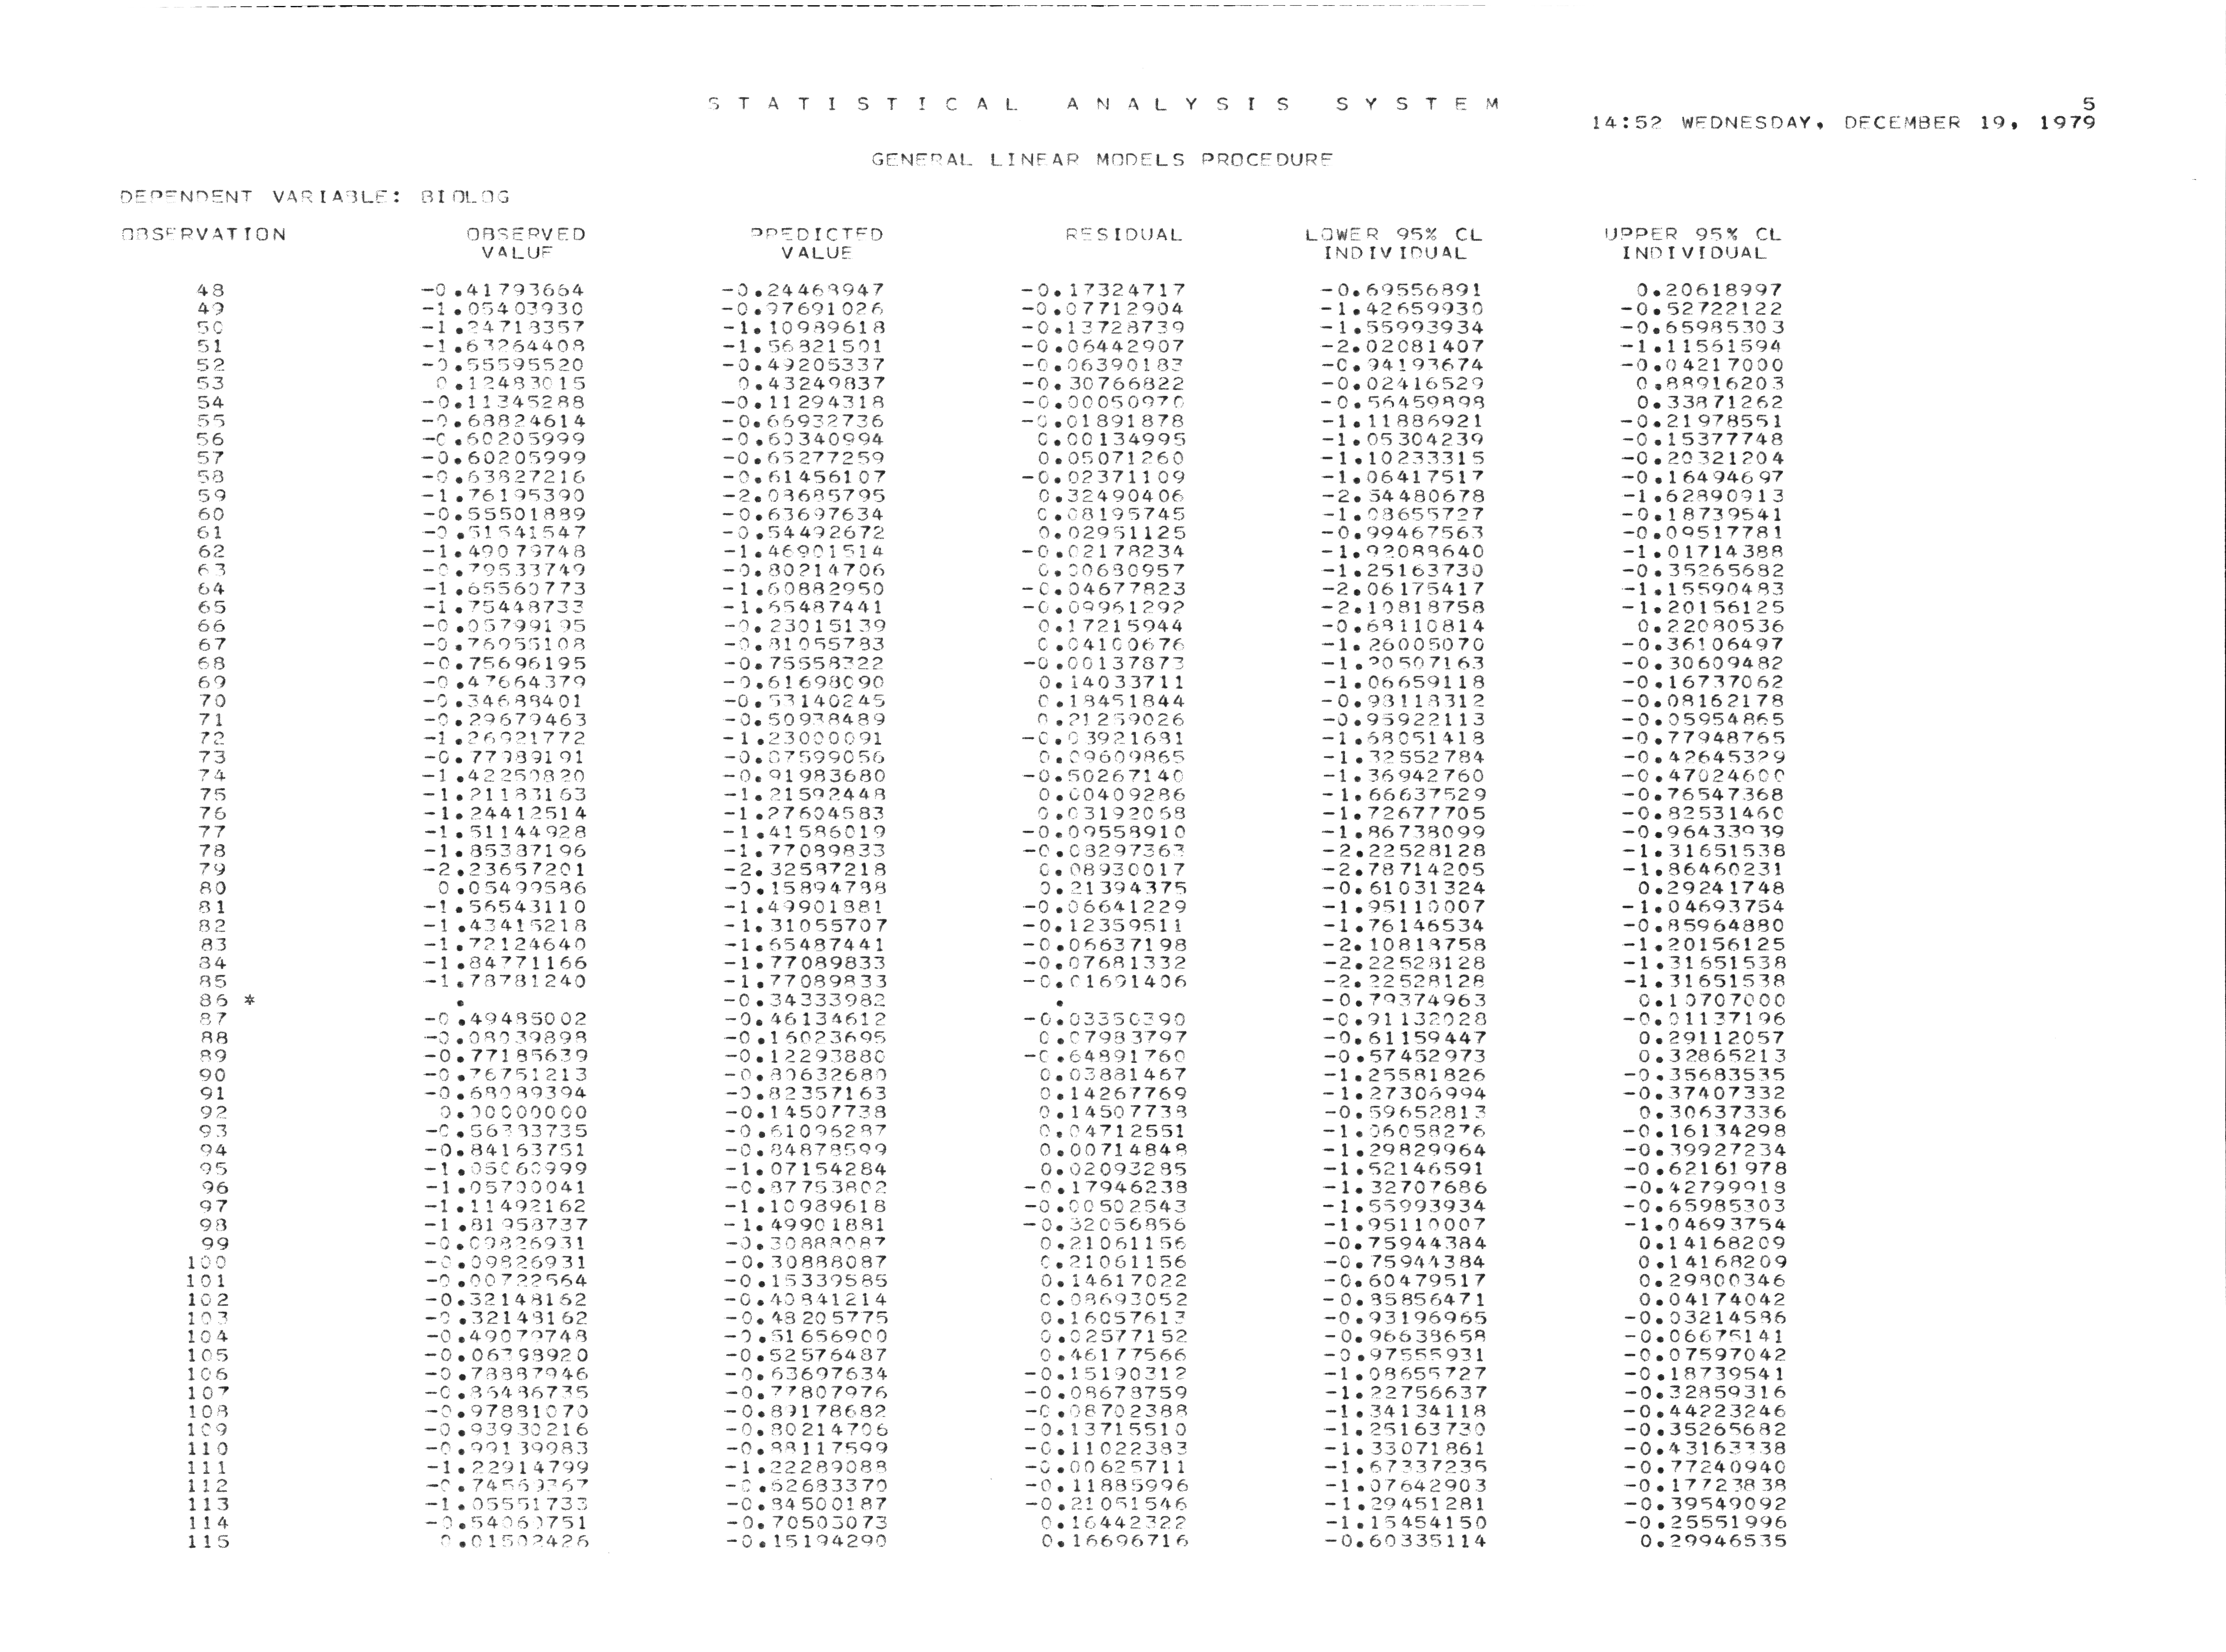

In [6]:
image = Image.open(SHEET).convert('L')
image = image.rotate(THETA, expand=True, fillcolor='white')
# image = ImageOps.scale(image, SCALE)
display(image)

### Binarize the image

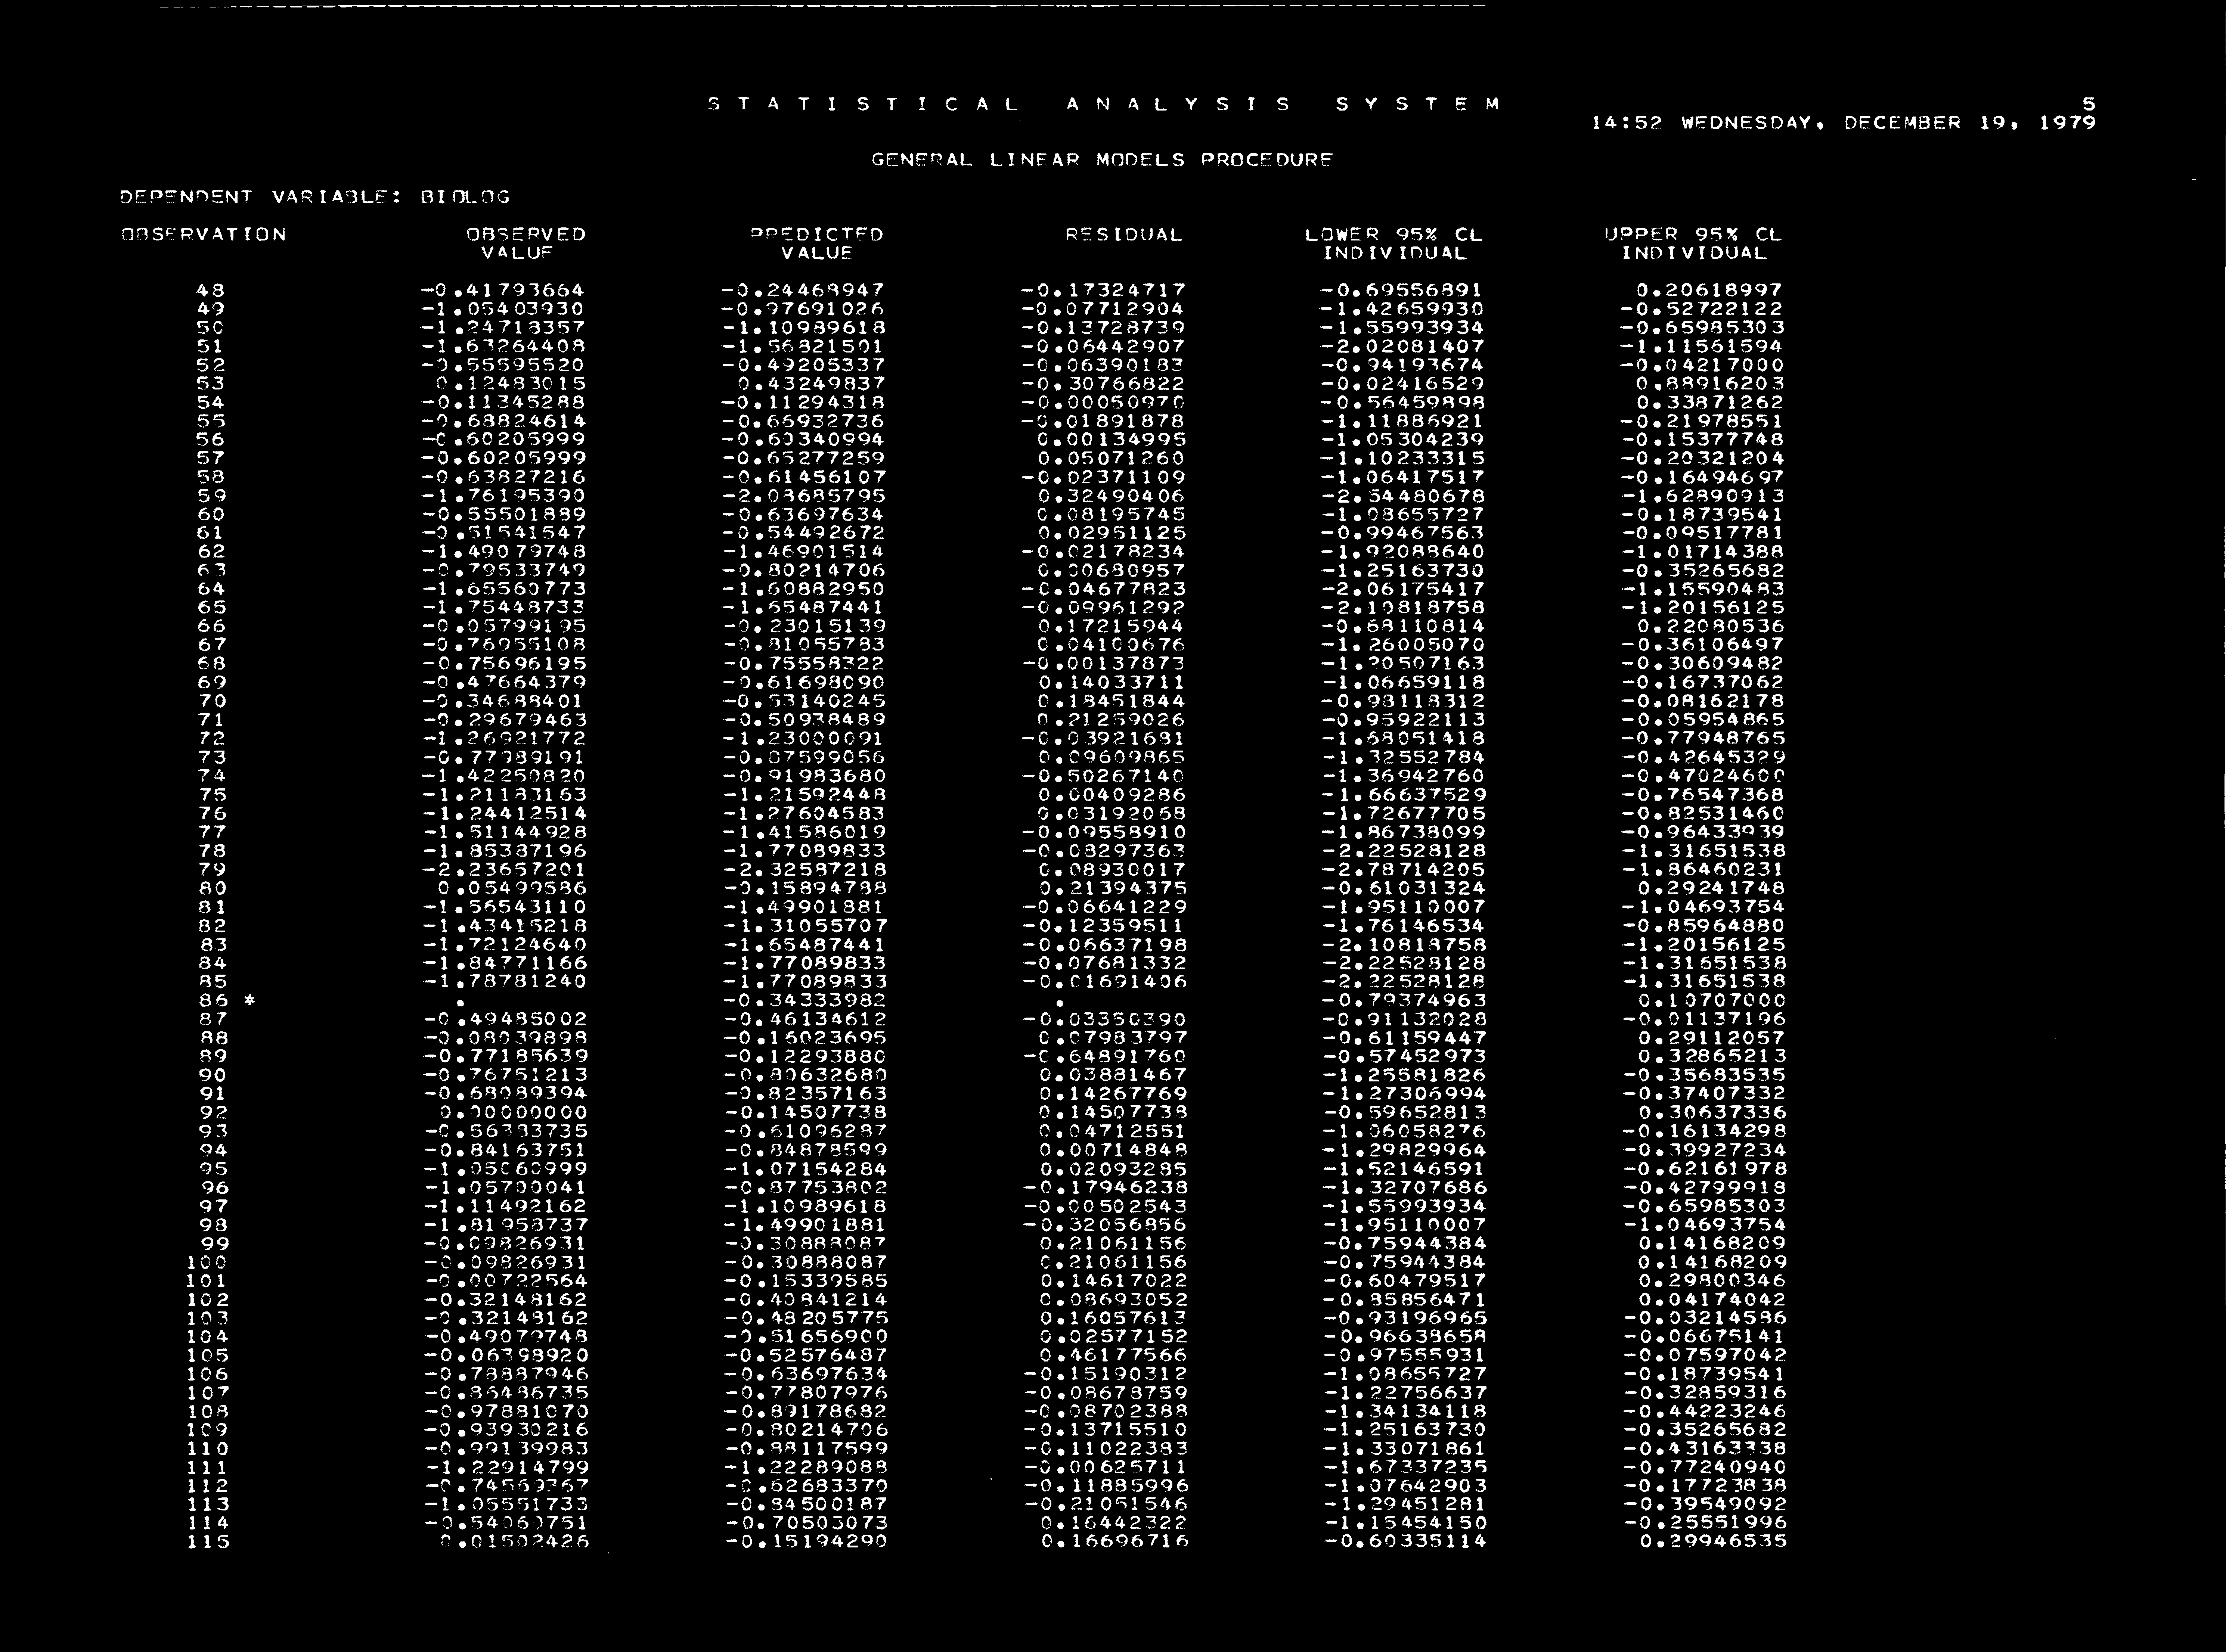

In [7]:
binary = image.point(lambda x: 255 if x < PIXEL_THRESHOLD else 0)
display(binary)

### Profile projection

In [8]:
def profile_projection(binary, threshold=20, axis=1):
    """Look for rows in the image via a profile projection."""
    data = np.array(binary).copy() / 255

    proj = data.sum(axis=axis)
    proj = proj > threshold
    proj = proj.astype(int)

    prev = np.insert(proj[:-1], 0, 0)
    curr = np.insert(proj[1:], 0, 0)
    where = np.where(curr != prev)[0]
    where = where.tolist()

    splits = np.array_split(proj, where)
    score = sum(len(s) for s in splits if s[0] == 0)

    where = where if where[0] == 0 else ([0] + where)
    where = [Where(w, s[0]) for w, s in zip(where, splits)]

    return Score(score, where)

### Find rows

In [9]:
score = profile_projection(binary, threshold=20)

In [10]:
top_lines = [w.row - PADDING for w in score.where if w.type == 1]
bottom_lines = [w.row + PADDING for w in score.where if w.type == 0][1:]

### Find characters in rows

In [11]:
width, height = image.size

marked = binary.convert('RGB')
draw = ImageDraw.Draw(marked)

In [12]:
for top, bottom in zip(top_lines, bottom_lines):
    if bottom - top < MIN_PIXELS:
        continue

    row = binary.crop((0, top, width, bottom))
    score = profile_projection(row, axis=0, threshold=1)

    row_width, row_height = row.size

    # draw.rectangle((1, top, row_width - 1, bottom), outline=(255, 0, 0))

    left_lines = [w.row - PADDING for w in score.where if w.type == 1]
    right_lines = [w.row + PADDING for w in score.where if w.type == 0][1:]

    for left, right in zip(left_lines, right_lines):
        if right - left > MIN_PIXELS:
            draw.rectangle((left, top, right, bottom), outline=(0, 255, 0))

In [13]:
path = DATA_DIR / 'marked.jpg'
marked.save(path, 'JPEG')

### Experiments to see if we can improve the image quality

In [14]:
# canny = np.asarray(binary)

# canny = feature.canny(canny, sigma=3, low_threshold=0.5, high_threshold=0.75)
# canny = skimage.img_as_ubyte(canny)

# canny = Image.fromarray(canny)

# path = DATA_DIR / 'canny.jpg'
# canny.save(path, 'JPEG')

# display(canny)

In [15]:
# selem = morph.disk(3)

# closed = np.asarray(binary)

# closed = morph.binary_closing(closed, selem)
# closed = skimage.img_as_ubyte(closed)

# closed = Image.fromarray(closed)

# path = DATA_DIR / 'closed.jpg'
# closed.save(path, 'JPEG')

# display(closed)

In [16]:
# skel = np.asarray(binary) / 255

# skel = morph.skeletonize(skel, method='lee')
# skel = skimage.img_as_ubyte(skel)

# skel = Image.fromarray(skel)

# path = DATA_DIR / 'skel.jpg'
# skel.save(path, 'JPEG')

# display(skel)

In [17]:
# thin = np.asarray(binary)

# thin = morph.thin(thin)
# thin = skimage.img_as_ubyte(thin)

# thin = Image.fromarray(thin)

# path = DATA_DIR / 'thin.jpg'
# thin.save(path, 'JPEG')

# display(thin)

### Deskew image

In [18]:
# NOTE: Pillow's rotate is only by whole numbers. Maybe an affine?

# for angle in np.arange(0.0, 2.1, 0.1):
#     rotated = binary.rotate(angle, fillcolor='black', expand=True)
#     best = profile_projection(rotated, angle, best)

# for angle in np.arange(178.0, 180.0, 0.1):
#     rotated = binary.rotate(angle, fillcolor='black', expand=True)
#     best = profile_projection(rotated, angle, best)